# Twitter Disasters Final Report | April 2023

## Authors

- [Giovanni Rivera](https://github.com/grivera64); Intro to Machine Learning, Section A
- [Oscar Jesus Zambrano](https://github.com/osc-zam22); Intro to Machine Learning, Section B

#### Setup Dependencies

In [1]:
# Ensure that we have the newest version of pip installed
%pip install -q --upgrade pip

# Install necessary libraries
%pip install -q numpy
%pip install -q pandas
%pip install -q matplotlib
%pip install -q seaborn
%pip install -q plotly

# Helps avoid showing plots in a separate line
# %matplotlib inline

%pip install -q scikit-learn
%pip install -q tensorflow

# Helps run plot_model from keras
%pip install pydot


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
# Import the modules
import numpy as np
import pandas as pd
import tensorflow as tf

from matplotlib import pyplot as plt
import seaborn as sns
import plotly.graph_objs as plotly
from sklearn import datasets

# Set the styling of the plt plots to darkgrid
sns.set_style('darkgrid')

# Removes error messsages and sets precision to 3 decimal places
import warnings
warnings.filterwarnings('ignore')
np.set_printoptions(precision=3, suppress=True)

## 1. Introduction

### Our Story:
TODO

### Our Task:

We are designing a Machine Learning model using Tensorflow/Keras to identify whether a given tweet is a natural distaster.

Throughout the notebook, we will refer to tweets about a natural distaster as part of the `postive class`, while tweets that aren't about a natural disaster as part of the `negative class`.

#### 1.1 Load the Data in a Colab Notebook

We use a dataset from the Kaggle competition [Tech Exchange 2023 ML Project](https://www.kaggle.com/competitions/techexchange-2023-ml-project).

You may find the dataset by navigating to the 'Data' tab in the link aforementioned. Under 'Data Explorer', you can download the following files:

- `train.csv`: Contains the training data; we will use this dataset for our training and validation data.
- `test.csv`: Contains our testing data; we will use this dataset for making our submissions to Kaggle.

In [3]:
# Please update the Path here to the location of your train.csv and test.csv files
path_to_csv = 'Data/techexchange-2023-ml-project'

# Load the Data Frames from the Training and Testing Data Frame
train_df = pd.read_csv(f'{path_to_csv}/train.csv')
test_df = pd.read_csv(f'{path_to_csv}/test.csv')
display(train_df.head())

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
# Separate Data Frame for input and outputs

input_names = ['id', 'keyword', 'location', 'text']
input_df = train_df[input_names]
display(input_df.head())

output_names = ['target']
output_df = train_df[output_names]
display(output_df.head())

,id,keyword,location,text
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or..."
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...


,target
0,1
1,1
2,1
3,1
4,1


### 1.2 Convert our data into numpy arrays for usage in our ML models.

Numpy will help us take full advantage of our GPU power to quickly perform training operations.

In [5]:
# Convert into numpy data
X_data = input_df.to_numpy()
Y_data = output_df.to_numpy().flatten()

print(X_data[:5])
print(Y_data[:5])

print(X_data.shape)
print(Y_data.shape)

[[1 nan nan
  'Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all']
 [4 nan nan 'Forest fire near La Ronge Sask. Canada']
 [5 nan nan
  "All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected"]
 [6 nan nan
  '13,000 people receive #wildfires evacuation orders in California ']
 [7 nan nan
  'Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school ']]
[1 1 1 1 1]
(7613, 4)
(7613,)


### 1.3 Split the training data into 90% training and 10% for validation.

We use Sklearn's train_test_split to split our `train.csv` dataset to create a 90:10 testing/validation split to use further down this notebook.

In [6]:
from sklearn.model_selection import train_test_split

# Split the data into train and test
X_train, X_validation, Y_train, Y_validation = train_test_split(X_data, Y_data, train_size=0.90)

In [7]:
# Going through a few examples in the training split

for index in range(2):
    print('Text')
    print(X_train[index])
    print()
    
    print('Is Natural Disaster?')
    print(Y_train[index], 'Yes' if Y_train[index] == 1 else 'No')
    print('======================')
    print()

Text
[1227 'blizzard' 'Ideally under a big tree'
 'That horrible moment when u open up the dryer and it looks like a snowy blizzard cuz u left a piece of paper in your jeans pocket ??']

Is Natural Disaster?
0 No

Text
[1276 'blood' 'Buenos Aires' '*se pone a cantar crying lightning*']

Is Natural Disaster?
0 No



## 2. Baseline

### 2.1 Create a Simple Baseline

In [8]:
# Returns a positive result, regardless of the input
def baseline_model(text_inputs):
    return 1

# Vectorized version of the method to apply to numpy arrays properly
baseline_model_np = np.vectorize(baseline_model, signature='(n) -> ()')

In [9]:
# Testing the baseline on the 
baseline_predictions_train = baseline_model_np(X_train)

for i in range(5):
    print('Input:')
    print(X_train[i])
    print()

    print('Output')
    print(Y_train[i])
    print()

    print('Prediction')
    print(baseline_predictions_train[i])
    print('==================')
    print()

Input:
[1227 'blizzard' 'Ideally under a big tree'
 'That horrible moment when u open up the dryer and it looks like a snowy blizzard cuz u left a piece of paper in your jeans pocket ??']

Output
0

Prediction
1

Input:
[1276 'blood' 'Buenos Aires' '*se pone a cantar crying lightning*']

Output
0

Prediction
1

Input:
[4173 'drown' 'Lynwood, CA'
 'gonna drown it in mustard and lemon pepper :)']

Output
0

Prediction
1

Input:
[5995 'hazardous' 'Far Away From Home'
 "@igmpj aren't dangling piercing crystals potentially hazardous to the eyes? :)"]

Output
0

Prediction
1

Input:
[6961 'massacre' nan
 '@KabarMesir @badr58 \r\nNever dies a big Crime like RABAA MASSACRE as long the revolution is being observed.\r\n#rememberRABAA']

Output
1

Prediction
1



### 2.2 Calculate the Log Loss of our baseline model

Since our baseline is simple, we can use this loss value to determine whether our models are more accurate than a naive approach.

In [10]:
# Calculates Log Loss
def calculate_loss(labels, predictions):
    epsilon = 0.000001  # Prevents taking the natural log of non-positive values
    ce_values = -labels * np.log(predictions + epsilon) - (1 - labels) * np.log(1 - predictions + epsilon)
    loss = ce_values.mean()
    return loss

In [11]:
# Calculate the loss on the training portion of our train data
training_loss = calculate_loss(Y_train, baseline_predictions_train)
print('Training Loss:', training_loss)

# Calculate the loss on the validation portion our our train data
baseline_predictions_validation = baseline_model_np(X_validation)
testing_loss = calculate_loss(Y_validation, baseline_predictions_validation)
print('Validation Loss:', testing_loss)

Training Loss: 7.842434330451692
Validation Loss: 8.213157445876602


### 2.3 Upload the baseline model to Kaggle

We can then upload a `submission.csv` file to Kaggle to find the F1 score of our baseline model.

In [12]:
# Create the submission CSV file for our Kaggle submission
def save_to_submissions_csv(text_inputs, prediction_labels, name='submission.csv'):
    print(f'Generating "{name}" file...')

    # Extract the ids of the text inputs and flatten to a 1D ndarray
    test_ids = text_inputs[:,0].flatten()

    # Write the submission file and save to 'submission.csv'
    np.savetxt(
        name,
        np.rec.fromarrays([test_ids, prediction_labels]),
        fmt=['%s', '%d'],
        delimiter=',',
        header='id,target',
        comments=''
    )

    # Show success!
    print(f'Successfully created "{name}"')

In [13]:
# Reformat the single training dataframe to an input dataframe
input_names = ['id', 'keyword', 'location', 'text']
test_input_df = test_df[input_names]

# Reformat the input dataframe into a numpy array for running through our model
test_input_np = test_input_df.to_numpy()

# Predict by using the baseline model on the test input and save to a .csv
baseline_predictions_test = baseline_model_np(test_input_np)
save_to_submissions_csv(test_input_np, baseline_predictions_test, 'baseline_submission.csv')

Generating "baseline_submission.csv" file...
Successfully created "baseline_submission.csv"


In [14]:
# Look at the first few predictions to ensure things went smoothly
pd.read_csv('baseline_submission.csv').head()

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1


## 3. Data Analysis

### 3.1 Explore the frequency of common words

Tweets can have all sorts of words inside of them, but we can always find common words that we can use for our vocabulary

The motivation for this graph to see what type of words are commonly used within our tweets dataset to see what we should and should not include in our vocabulary.

In [15]:
from collections import Counter

# Plots the frequency of the top commonly used words in the provided tweets in
# the positive and negative class
def plot_frequency(tweets_np, labels_np, max_word_num=20):
    # Creates a counter that keeps track of the frequency of words (similar to defaultdict)
    pos_counter = Counter()
    neg_counter = Counter()
    tweets_np = np.copy(tweets_np) # Deep Copy of input

    # Total Counter Variables
    pos_counter_all = 0
    neg_counter_all = 0

    # Go through the tweets dataset
    total_words = set()
    for entry_index in range(tweets_np.shape[0]):
        # Flatten all of the features into a single string
        words = ' '.join([str(feature).lower() for feature in tweets_np[entry_index]])
        # Count the frequency of each word
        for word in words.split():
            # Group all links as 1 token
            if word.startswith('http'):
                word = '<LINK>'
            # Group all articles as 1 token
            elif word in ['the', 'a', 'an']:
                word = '<ARTICLE>'
            
            if labels_np[entry_index]:
                pos_counter[word] += 1  # Positive entry
                pos_counter_all += 1
            else:
                neg_counter[word] += 1  # Negative entry
                neg_counter_all += 1

            # For Debug purposes, saving all of the words we encounter
            total_words.add(word)
    
    # Extract at most max_word_num words that are the most common words
    # for both classes (and removes overlap)
    top_pos_words = [word for word, _ in pos_counter.most_common(max_word_num // 2)]
    top_neg_words = [word for word, _ in neg_counter.most_common(max_word_num // 2)]
    top_words = set(top_pos_words + top_neg_words)

    # Create a Data Frame for the collected data
    result = {
        'word': [word for word in top_words],
        'pos count': [pos_counter[word] for word in top_words],
        'neg count': [neg_counter[word] for word in top_words],
        '% chance is pos': [(pos_counter[word] / (pos_counter[word] + neg_counter[word])) * 100 for word in top_words]
    }
    word_count_df = pd.DataFrame(data=result, columns=result.keys())
    word_count_df = word_count_df.set_index('word')
    display(word_count_df)
    
    # Plot a bar graph that groups pos and neg count for a few of the most used words
    pd.concat([word_count_df[['pos count']], word_count_df[['neg count']]], axis=1).plot.bar()

    print(f'DEBUG: Total Words Len: {len(total_words)}')
    print(f'DEBUG: Total Positive Examples: {pos_counter_all}')
    print(f'DEBUG: Total Negative Examples: {neg_counter_all}')

,pos count,neg count,% chance is pos
word,,,
be,113,287,28.250000
after,181,75,70.703125
this,179,287,38.412017
i,292,1061,21.581670
you,125,629,16.578249
<ARTICLE>,2426,3372,41.842014
nan,1117,1479,43.027735
as,171,160,51.661631
to,761,1195,38.905930


DEBUG: Total Words Len: 33580
DEBUG: Total Positive Examples: 61864
DEBUG: Total Negative Examples: 80205


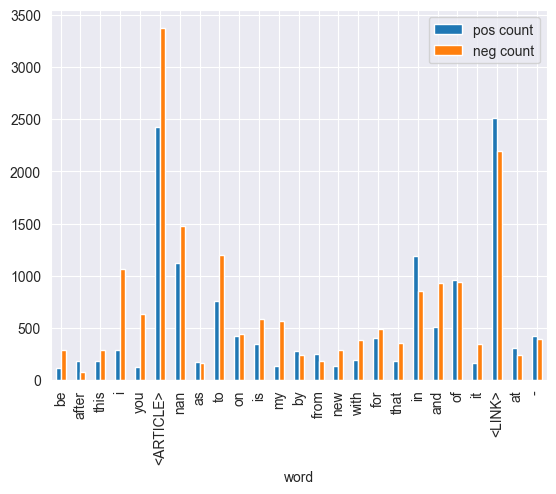

In [16]:
# Display and plot at most 40 words from the X_data set
plot_frequency(X_data, Y_data, max_word_num=40)

In [17]:
from collections import defaultdict

def length_plot(tweets_np , labels_np, interval_list):

    # initializes maps to count based on intervals of words
    pos_intervals = defaultdict(int)
    neg_intervals = defaultdict(int)

    # Convert the interval list into ranges for use below
    interval_map = {}
    for interval in interval_list:
        # Parses interval strings into useable ranges
        if '-' in interval:
            start, end = map(lambda x: int(x), interval.split('-'))
        else:
            start, end = interval.split('+')[0], 285

        interval_map[interval] = range(int(start), int(end) + 1)

    # Track the counts of positive and negative inputs for each range from above
    for entry_index in range(tweets_np.shape[0]):
        # Flatten all of the features into a single string
        words = ' '.join([str(feature) for feature in tweets_np[entry_index]]).split()

        for interval in interval_list:
            # Ignore words counts outside of our intervals
            if len(words) not in interval_map[interval]:
                continue

            # Updates the counts of positive and negative entries in the dictionary
            # based on the interval they are in
            if labels_np[entry_index]:
                pos_intervals[interval] += 1
            else:
                neg_intervals[interval] += 1

    # Create a Data Frame for the collected data
    result= {
        'interval' : [ interval for interval in interval_list],
        'pos intervals' : [pos_intervals[interval] for interval in interval_list],
        'neg intervals' : [neg_intervals[interval] for interval in interval_list],
        '% chance is pos': [(pos_intervals[interval] / (pos_intervals[interval] + neg_intervals[interval])) * 100 for interval in interval_list],
    }
    word_count_df = pd.DataFrame(data = result , columns=result.keys())
    word_count_df = word_count_df.set_index('interval')

    # Plot and Display the collected data
    pd.concat([word_count_df[['pos intervals']], word_count_df[['neg intervals']]], axis=1).plot.bar()
    display(word_count_df)

    # Debugging code
    print(neg_intervals)
    print(pos_intervals)

,pos intervals,neg intervals,% chance is pos
interval,,,
0-5,2,28,6.666667
6-10,164,463,26.156300
11-15,740,1017,42.117245
16-20,1041,1165,47.189483
21-25,973,1010,49.067070
26-30,317,552,36.478711
31-35,34,106,24.285714
36+,0,1,0.000000


defaultdict(<class 'int'>, {'6-10': 463, '0-5': 28, '16-20': 1165, '11-15': 1017, '21-25': 1010, '26-30': 552, '31-35': 106, '36+': 1})
defaultdict(<class 'int'>, {'16-20': 1041, '6-10': 164, '21-25': 973, '11-15': 740, '26-30': 317, '31-35': 34, '0-5': 2, '36+': 0})


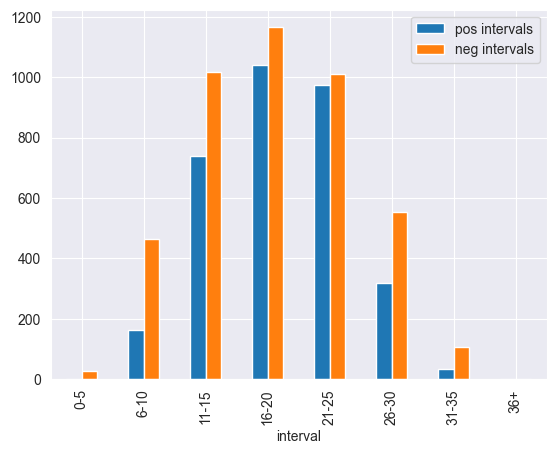

In [18]:
# Plots the count of positive and negative classes of X_data based on the given intervals
intervals = ['0-5', '6-10' , '11-15' , '16-20' , '21-25' , '26-30' , '31-35', '36+']
length_plot(X_data, Y_data, intervals)

## 4. Our Experiments

### 4.1 Normalize our data

Since tweets can contain lots of punctuation, we want to specify a standardization to sanitize our inputs. 
> **NOTE** Though standarization helps ensure that our model works for unusual input, there may be a lost 
> of information when applying normalizations.

#### 4.1.1 Normalization Technique 1: Remove punctuation and Links

In [19]:
# Stardardizes the input
def normalize_punctuation_and_links(tweets_text, show_debug=False):
    # Make all letters lowercase
    result_tensor = tf.strings.lower(tweets_text)

    # Replace links with <LINK> token
    link_regex = r'(https?:\/\/)([\da-z\.-]+)\.([a-z\.]{2,6})([\/\w\.-]*)'
    result_tensor = tf.strings.regex_replace(result_tensor, link_regex, '<LINK>')

    # Remove punctuation (but don't remove <> from our Link tokens)
    punctuation_regex = r'[^\w\s<>]'
    result_tensor = tf.strings.regex_replace(result_tensor, punctuation_regex, ' ')

    # Remove extra spaces
    multi_space_regex = r'\s{2,}'
    result_tensor = tf.strings.regex_replace(result_tensor, multi_space_regex, ' ')

    if show_debug:
        print('DEBUG: ', end='')
        tf.print(result_tensor)

    return result_tensor

normalize_punctuation_and_links('I.am.cool  http://www.example.com, https://github.com/example', show_debug=True)

DEBUG: i am cool <LINK> <LINK>


<tf.Tensor: shape=(), dtype=string, numpy=b'i am cool <LINK> <LINK>'>

### 4.2 Build Our Model(s)

#### 4.2.1 FFNN Model (Bag Of Embeddings)

In [20]:
def build_ffnn_model(tweets_np, max_vocab, max_tokens, embedding_dim):
    # Remove randomness
    tf.keras.backend.clear_session()
    tf.keras.utils.set_random_seed(0)
    
    # Build the normalization layer ahead of time
    norm_layer = tf.keras.layers.TextVectorization(
        max_tokens,
        standardize=normalize_punctuation_and_links,
        split='whitespace',
        # output_mode='tf_idf',
        output_mode='int',
        # pad_to_max_tokens=True,
        encoding='utf-8',
        name='Normalization_Layer',
        output_sequence_length=max_tokens,
    )
    norm_layer.adapt(tweets_np, batch_size=64)

    # display(norm_layer.get_vocabulary())

    # Build our FFNN Model using embeddings and average pooling
    model = tf.keras.models.Sequential()
    model.add(tf.keras.Input(shape=(1,), dtype=tf.string))
    model.add(norm_layer)
    model.add(tf.keras.layers.Embedding(
        input_dim=max_vocab,
        output_dim=embedding_dim,
        input_length=max_tokens,
        name='Embeddings_Layer',
    ))
    model.add(tf.keras.layers.GlobalMaxPooling1D(
        name='Max_Pool_Layer'
    ))
    model.add(tf.keras.layers.Dense(
        units=32,
        # activation='relu',
        activation='sigmoid',
        name='Dense_Layer_1',
    ))
    model.add(tf.keras.layers.Dense(
        units=32,
        # activation='relu',
        activation='sigmoid',
        name='Dense_Layer_2',
    ))
    model.add(tf.keras.layers.Dense(
        units=1,
        activation='sigmoid',
        name='Output_Layer',
    ))

    # Compile and return the model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [21]:
ffnn_model = build_ffnn_model(X_train[:,3], 20000, 300, 9)
display(ffnn_model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Normalization_Layer (TextVe  (None, 300)              0         
 ctorization)                                                    
                                                                 
 Embeddings_Layer (Embedding  (None, 300, 9)           180000    
 )                                                               
                                                                 
 Max_Pool_Layer (GlobalMaxPo  (None, 9)                0         
 oling1D)                                                        
                                                                 
 Dense_Layer_1 (Dense)       (None, 32)                320       
                                                                 
 Dense_Layer_2 (Dense)       (None, 32)                1056      
                                                        

None

#### 4.2.2 CNN Model

In [22]:
def build_cnn_model(tweets_np, max_vocab, max_tokens, embedding_dim):
    # Remove randomness
    tf.keras.backend.clear_session()
    tf.keras.utils.set_random_seed(0)
    
    # Build the normalization layer ahead of time
    norm_layer = tf.keras.layers.TextVectorization(
        max_tokens,
        standardize=normalize_punctuation_and_links,
        split='whitespace',
        # output_mode='tf_idf',
        output_mode='int',
        # pad_to_max_tokens=True,
        encoding='utf-8',
        name='Normalization_Layer',
        output_sequence_length=max_tokens,
    )
    norm_layer.adapt(tweets_np, batch_size=64)

    # display(norm_layer.get_vocabulary())

    # Build our CNN Model using Keras' Functional API
    input_layer = tf.keras.Input(shape=(1,), dtype=tf.string, name='Input Layer')
    norm_layer = norm_layer(input_layer)
    embedding_layer = tf.keras.layers.Embedding(
        input_dim=max_vocab,
        output_dim=embedding_dim,
        input_length=max_tokens,
        name='Embeddings_Layer',
    )(norm_layer)
    
    conv_1 = tf.keras.layers.Conv1D(
        filters=16,
        kernel_size=3,
        padding='same',
        activation='relu',
        name='Conv_Layer_1_1',
    )(embedding_layer)
    conv_2 = tf.keras.layers.Conv1D(
        filters=16,
        kernel_size=4,
        padding='same',
        activation='relu',
        name='Conv_Layer_1_2',
    )(embedding_layer)
    conv_3 = tf.keras.layers.Conv1D(
        filters=16,
        kernel_size=5,
        padding='same',
        activation='relu',
        name='Conv_Layer_1_3',
    )(embedding_layer)

    concat_layer = tf.keras.layers.Concatenate(name='Concatenate_Layer')([conv_1, conv_2, conv_3])
    dropout_layer = tf.keras.layers.Dropout(rate=0.05)(concat_layer)
    max_pool_layer = tf.keras.layers.MaxPool1D(pool_size=max_tokens, name='Max_Pool_Layer')(dropout_layer)
    flatten_layer = tf.keras.layers.Flatten(name='Flatten_Layer_1')(max_pool_layer)
    
    hidden_layer = tf.keras.layers.Dense(
        units=32,
        activation='sigmoid',
        name='Hidden_Layer_1',
    )(flatten_layer)
    output_layer = tf.keras.layers.Dense(
        units=1,
        activation='sigmoid',
        name='Output_Layer',
    )(hidden_layer)

    model = tf.keras.Model(
        inputs=input_layer,
        outputs=output_layer,
        name='CNN_Model',
    )

    # Compile and return the model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [23]:
cnn_model = build_cnn_model(X_train[:,3], 20000, 300, 9)
display(cnn_model.summary())

Model: "CNN_Model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input Layer (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 Normalization_Layer (TextVecto  (None, 300)         0           ['Input Layer[0][0]']            
 rization)                                                                                        
                                                                                                  
 Embeddings_Layer (Embedding)   (None, 300, 9)       180000      ['Normalization_Layer[0][0]']    
                                                                                                  
 Conv_Layer_1_1 (Conv1D)        (None, 300, 16)      448         ['Embeddings_Layer[0][0]'

None

### 4.3 RNN model



In [ ]:
def build_rnn_model(tweets_np, max_vocab, max_tokens, embedding_dim):
    
    tf.keras.backend.clear_session()
    tf.keras.utils.set_random_seed(0)


    # create normalized vocab
    norm = tf.keras.

    

## 5. Error Analysis

In [24]:
def plot_history(history, epochs):
    history = pd.DataFrame(history)

    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss vs Epoch')

    plt.plot(list(range(1, epochs + 1)), history['loss'], label="Train")
    plt.plot(list(range(1, epochs + 1)), history['val_loss'], label="Validation")

    plt.legend(loc='best')
    plt.show()

    print('Loss:', history['loss'].iloc[-1])
    print('Val Loss:', history['val_loss'].iloc[-1])

    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (in %)')
    plt.title('Accuracy vs Epoch')

    plt.plot(list(range(1, epochs + 1)), history['accuracy'] * 100, label="Train")
    plt.plot(list(range(1, epochs + 1)), history['val_accuracy'] * 100, label="Validation")

    plt.legend(loc='best')
    plt.show()

    print('Accuracy:', history['accuracy'].iloc[-1])
    print('Val Accuracy:', history['val_accuracy'].iloc[-1])

In [26]:
def plot_predictions(predictions, actual):
    from matplotlib.ticker import PercentFormatter
    plt.title('Prediction Distribution')
    plt.xlabel('Positive Confidence Level (in %)')
    plt.ylabel('# of predictions')
    plt.gca().xaxis.set_major_formatter(PercentFormatter())

    plt.hist([predictions[actual == 0] * 100, predictions[actual == 1] * 100], label=['negative', 'positive'])
    plt.legend(loc='best')
    plt.show()

In [27]:
def plot_difference(predictions, actual):
    plt.title('Prediction Difference Distribution')
    plt.xlabel('Positive Confidence Lavel (in %)')
    plt.ylabel('Difference')

    diff = abs(predictions - actual)

    plt.hist([diff[actual == 0] * 100, diff[actual == 1] * 100], label=['negative', 'positive'])
    plt.show()

### 5.1 Train and Anaylze the FFNN Model

Epoch 1/16
386/386 [==============================] - 2s 4ms/step - loss: 0.6808 - accuracy: 0.5682 - val_loss: 0.6707 - val_accuracy: 0.6137
Epoch 2/16
386/386 [==============================] - 1s 3ms/step - loss: 0.6099 - accuracy: 0.6826 - val_loss: 0.5818 - val_accuracy: 0.7041
Epoch 3/16
386/386 [==============================] - 1s 3ms/step - loss: 0.5356 - accuracy: 0.7366 - val_loss: 0.5438 - val_accuracy: 0.7391
Epoch 4/16
386/386 [==============================] - 1s 3ms/step - loss: 0.4925 - accuracy: 0.7651 - val_loss: 0.5209 - val_accuracy: 0.7420
Epoch 5/16
386/386 [==============================] - 1s 3ms/step - loss: 0.4697 - accuracy: 0.7825 - val_loss: 0.5142 - val_accuracy: 0.7420
Epoch 6/16
386/386 [==============================] - 1s 3ms/step - loss: 0.4567 - accuracy: 0.7891 - val_loss: 0.5181 - val_accuracy: 0.7434
Epoch 7/16
386/386 [==============================] - 1s 4ms/step - loss: 0.4490 - accuracy: 0.7912 - val_loss: 0.5173 - val_accuracy: 0.7434
Epoch 

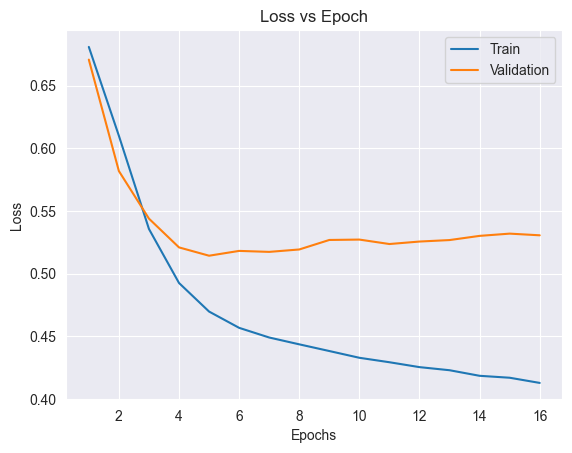

Loss: 0.4127620458602905
Val Loss: 0.5305292010307312


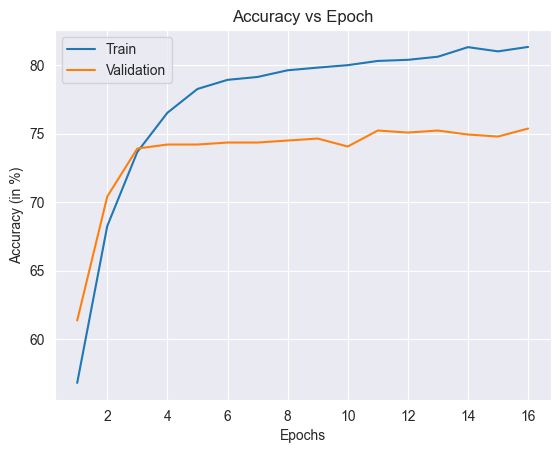

Accuracy: 0.8131386637687683
Val Accuracy: 0.7536442875862122


In [28]:
train_and_analyze_model(
    ffnn_model,
    X_train,
    Y_train,
    num_of_epochs=16,
    num_per_batch=16,
    validation=0.1,
)

In [29]:
ffnn_train_predictions = ffnn_model.predict(X_train[:, 3]).flatten()
ffnn_train_loss = calculate_loss(Y_train, ffnn_train_predictions)
print(f'Train Loss: {ffnn_train_loss}')

ffnn_validation_predictions = ffnn_model.predict(X_validation[:, 3]).flatten()
ffnn_validation_loss = calculate_loss(Y_validation, ffnn_validation_predictions)
print(f'Val Loss: {ffnn_validation_loss}')

215/215 [==============================] - 0s 2ms/step
Train Loss: 0.4135305173191431
24/24 [==============================] - 0s 2ms/step
Val Loss: 0.5243603869205649


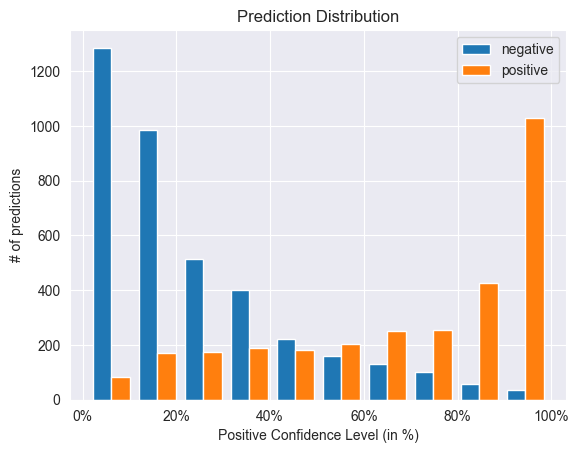

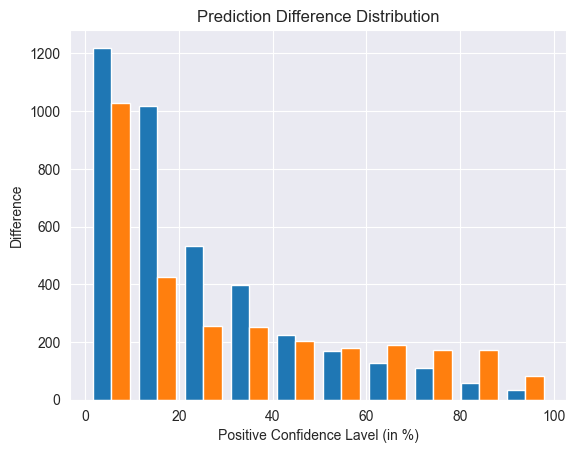

In [30]:
plot_predictions(ffnn_train_predictions, Y_train)
plot_difference(ffnn_train_predictions, Y_train)

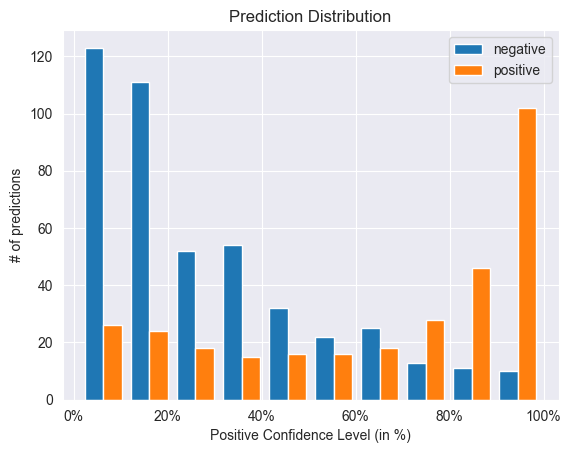

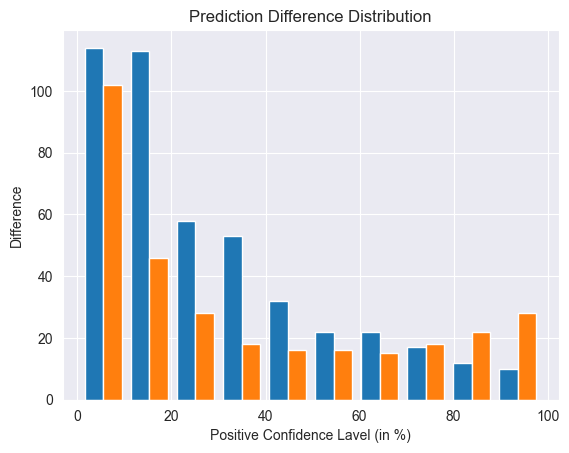

In [31]:
plot_predictions(ffnn_validation_predictions, Y_validation)
plot_difference(ffnn_validation_predictions, Y_validation)

In [32]:
ffnn_predictions = ffnn_model.predict(test_input_np[:, 3]).flatten()

# Apply threshold
THRESHOLD = 0.7
ffnn_predictions[ffnn_predictions >= THRESHOLD] = 1
ffnn_predictions[ffnn_predictions < THRESHOLD] = 0

save_to_submissions_csv(test_input_np, ffnn_predictions, 'ffnn_submission.csv')

102/102 [==============================] - 0s 2ms/step
Generating "ffnn_submission.csv" file...
Successfully created "ffnn_submission.csv"


In [33]:
pd.read_csv('ffnn_submission.csv').head()

,id,target
0,0,0
1,2,1
2,3,0
3,9,0
4,11,1


### 5.2 Train and Evaluate the CNN Model

Epoch 1/16
386/386 [==============================] - 5s 8ms/step - loss: 0.6937 - accuracy: 0.5655 - val_loss: 0.6199 - val_accuracy: 0.6429
Epoch 2/16
386/386 [==============================] - 3s 7ms/step - loss: 0.5683 - accuracy: 0.7150 - val_loss: 0.5339 - val_accuracy: 0.7362
Epoch 3/16
386/386 [==============================] - 3s 8ms/step - loss: 0.4867 - accuracy: 0.7705 - val_loss: 0.5155 - val_accuracy: 0.7405
Epoch 4/16
386/386 [==============================] - 3s 7ms/step - loss: 0.4650 - accuracy: 0.7846 - val_loss: 0.5172 - val_accuracy: 0.7464
Epoch 5/16
386/386 [==============================] - 3s 7ms/step - loss: 0.4561 - accuracy: 0.7909 - val_loss: 0.5182 - val_accuracy: 0.7449
Epoch 6/16
386/386 [==============================] - 3s 7ms/step - loss: 0.4480 - accuracy: 0.7927 - val_loss: 0.5217 - val_accuracy: 0.7376
Epoch 7/16
386/386 [==============================] - 3s 7ms/step - loss: 0.4421 - accuracy: 0.7969 - val_loss: 0.5222 - val_accuracy: 0.7391
Epoch 

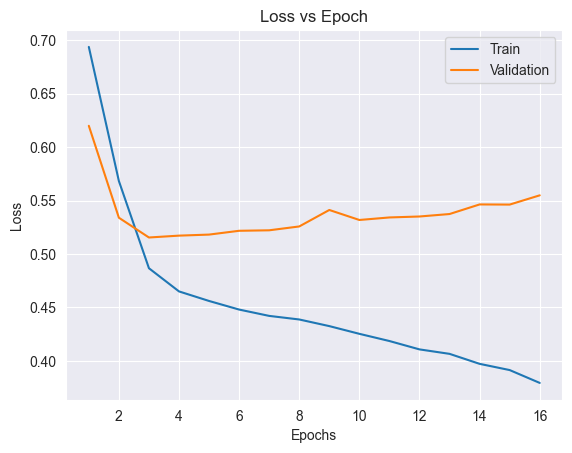

Loss: 0.37942954897880554
Val Loss: 0.5548871755599976


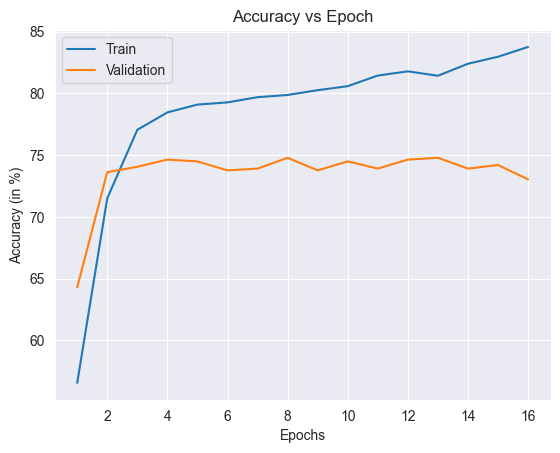

Accuracy: 0.8376318216323853
Val Accuracy: 0.7303206920623779


In [34]:
train_and_analyze_model(
    cnn_model,
    X_train,
    Y_train,
    num_of_epochs=16,
    num_per_batch=16,
    validation=0.1,
)

In [35]:
cnn_train_predictions = cnn_model.predict(X_train[:, 3]).flatten()
cnn_train_loss = calculate_loss(Y_train, cnn_train_predictions)
print(f'Train Loss: {cnn_train_loss}')

cnn_validation_predictions = cnn_model.predict(X_validation[:, 3]).flatten()
cnn_validation_loss = calculate_loss(Y_validation, cnn_validation_predictions)
print(f'Val Loss: {cnn_validation_loss}')

215/215 [==============================] - 1s 3ms/step
Train Loss: 0.3760965785001649
24/24 [==============================] - 0s 3ms/step
Val Loss: 0.5395248092592876


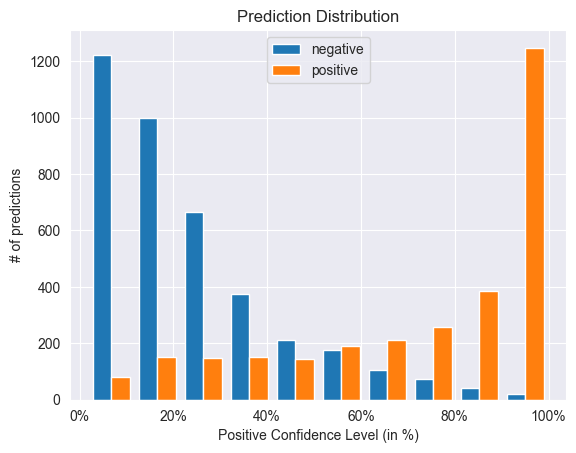

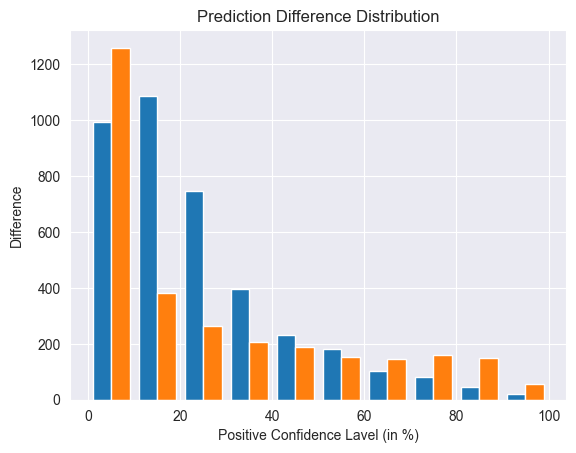

In [36]:
plot_predictions(cnn_train_predictions, Y_train)
plot_difference(cnn_train_predictions, Y_train)

### 

In [ ]:

train_and_analyze_model(
    ffnn_model,
    X_train,
    Y_train,
    num_of_epochs=15,
    num_per_batch=32,
    validation=0.1,
)

In [ ]:
rnn_predictions = cnn_model.predict(X_train[:, 3]).flatten()
cnn_loss = calculate_loss(Y_train, cnn_predictions)
print(f'Train Loss: {cnn_loss}')

cnn_predictions = cnn_model.predict(X_validation[:, 3]).flatten()
cnn_loss = calculate_loss(Y_validation, cnn_predictions)
print(f'Val Loss: {cnn_loss}')

In [39]:
pd.read_csv('ffnn_submission.csv').head()

,id,target
0,0,0
1,2,1
2,3,0
3,9,0
4,11,1


## 6. Conclusion

TODO